In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from nibabel import affines
from dotenv import load_dotenv
from sklearn.neighbors import KernelDensity
%config InlineBackend.figure_format='retina'
load_dotenv()

output = os.getenv('OUTPUT')
hipp_unfold_dir = os.getenv('HIPP_UNFOLD_DIR')

subject = 'HCD0001305'
hemi = 'L'
rois = ['V1','V2','V3','V4']
display_slice = 110



In [2]:
# T1 in cropped HippUnfold space.
t1_path = f'{hipp_unfold_dir}/sub-{subject}/anat/sub-{subject}_hemi-{hemi}_space-cropT1w_desc-preproc_T1w.nii.gz'

# N-streamline length numpy arrays with glasser ROIs and streamline-endpoint coordinates.
streamline_rois        = np.load(f'{output}/{subject}/streamlines-glasser_ROIs.npy')
streamline_hipp_coords = np.load(f'{output}/{subject}/streamlines-hipp_coordinates_space-T1.npy')


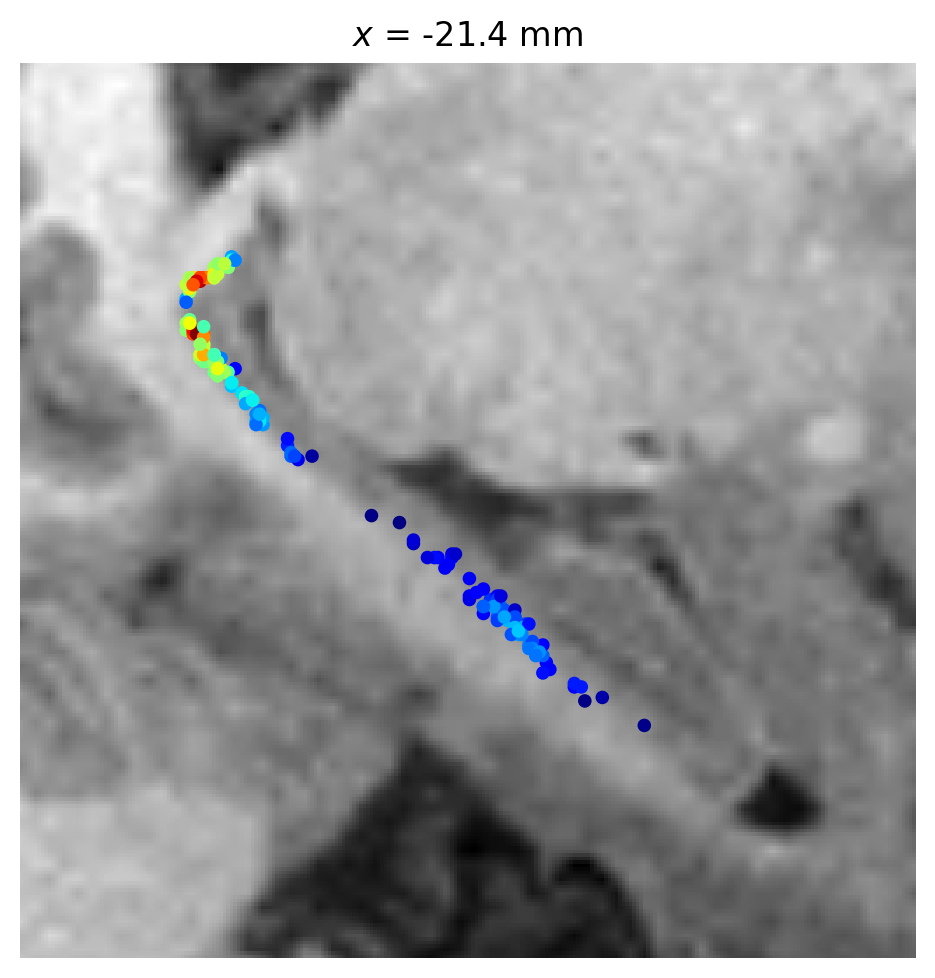

In [ ]:
streamline_idx = np.argwhere(np.isin(streamline_rois, rois)).flatten()


# Load T1.
nii = nib.load(t1_path)
data = nii.get_fdata()
inv_affine = np.linalg.inv(nii.affine)

vox_coords =  nib.affines.apply_affine(inv_affine, streamline_hipp_coords[streamline_idx])
vox_coords = np.round(vox_coords).astype(int)

# Get streamline-endpoint density.
kde = KernelDensity(bandwidth=1.5).fit(vox_coords)
dens = np.exp(kde.score_samples(vox_coords))


# Plot
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(
    data[display_slice, :, :].T,
    cmap='gray',
    origin='lower'
)

mask = vox_coords[:, 0] == display_slice
ax.scatter(
    vox_coords[mask, 1],
    vox_coords[mask, 2],
    c=dens[mask],
    cmap='jet',
    s=15
)

slice_mm = np.round(streamline_hipp_coords[streamline_idx][mask][:, 0].mean(), 1)
ax.set_title(f'$x$ = {slice_mm} mm')
ax.axis('off')

plt.tight_layout()
plt.savefig(f'plots/endpoint_density_V1_slice.svg')
plt.show()
